In [1]:
import os
import re
import imageio as iio
from pathlib import Path
import numpy as np
from glob import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt

#AIRXD model import
from airxd.mask import MASK
from airxd_cnn.cnn import ARIXD_CNN as cmodel
from airxd.model import ARIXD
from airxd.dataset import Dataset, parse_imctrl
from torchvision.transforms import v2
import torch

In [2]:
def plot_im_and_mask(image_path, mask_path):
    #Load image and mask
    image = iio.v2.volread(image_path)
    mask = iio.v2.volread(mask_path)

    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(image, cmap='binary', origin='lower',)
    ax[0].set_title('Raw data')
    ax[0].axis('off')
    ax[1].imshow(mask, cmap='binary', origin='lower',)
    ax[1].set_title('Mask')
    ax[1].axis('off')

# Troubleshooting

In [6]:
x = np.arange(5)
x[:,np.newaxis]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [1]:
import einops
import torch
import numpy as np

x = torch.rand((10,1,2880,2880))
y = torch.rand((10,1,2880,2880))

In [2]:
import qlty
from qlty import qlty2D

quilt = qlty2D.NCYXQuilt(X=2880,
                         Y=2880,
                         window=(256,256),
                         step=(128,128),
                         border=(64,64),
                         border_weight=0)

In [3]:
x_bits, y_bits = quilt.unstitch_data_pair(x,y)
print("x shape: ",x.shape)
print("y shape: ",y.shape)
print("x_bits shape:", x_bits.shape)
print("y_bits shape:", y_bits.shape)

x shape:  torch.Size([10, 1, 2880, 2880])
y shape:  torch.Size([10, 1, 2880, 2880])
x_bits shape: torch.Size([4840, 1, 256, 256])
y_bits shape: torch.Size([4840, 1, 256, 256])


In [5]:
#Calculate size of x_bits in megabytes
x_bits.shape[0] * x_bits.itemsize / 1e6 #size of x_bits in megabytes

tensor([[0.4766, 0.1971, 0.0431,  ..., 0.0057, 0.7003, 0.9482],
        [0.0251, 0.6186, 0.1771,  ..., 0.4878, 0.6418, 0.1646],
        [0.0487, 0.5537, 0.1498,  ..., 0.0083, 0.1717, 0.7881],
        ...,
        [0.3662, 0.4824, 0.6656,  ..., 0.0815, 0.6366, 0.3154],
        [0.0837, 0.2683, 0.6037,  ..., 0.2525, 0.7902, 0.2660],
        [0.3648, 0.0858, 0.0980,  ..., 0.9895, 0.4325, 0.4008]])

In [4]:
y_mock = torch.rand( (8410,17,16,16))

In [5]:
y_stiched, weights = quilt.stitch(y_mock)

In [10]:
weights[0][0]

tensor(1.0000e-08)

In [5]:
import skimage
from skimage.morphology import disk
from skimage.filters import rank
from skimage import exposure

def normalize(image):
        footprint = disk(32)
        img = np.log(np.abs(image) - np.min(image) + 1e-7)
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = skimage.util.img_as_ubyte(img)
        img_eq = rank.equalize(img, footprint)
        img_eq = img_eq.astype(float)/256.0
        return img_eq  

In [ ]:
from PIL import Image
import re

#In the line below, filter out for any names with 'normalized'

classes = [f for f in glob('data/*') if not re.search(r'normalized', f)]
mask_paths = [f for f in glob('data/*/masks/*.tif')]
image_paths= [f for f in glob('data/*/*.tif') if not re.search(r'mask', f) and not re.search(r'normalized', f)]


In [24]:
temp_path = 'data/Perfect/masks/'
inp_path = 'data/Perfect/'

inp_images = glob(inp_path + '*.tif')
images = glob(temp_path + '*.tif')

#sort inp_images and images
inp_images.sort(key=lambda x: x.split('/')[-1])
images.sort(key=lambda x: x.split('/')[-1])

inp_images, images

(['data/Perfect/LNO_OA_ch1_RTto720_d700-00000.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00001.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00002.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00003.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00004.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00005.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00006.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00007.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00008.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00009.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00010.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00011.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00012.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00013.tif',
  'data/Perfect/LNO_OA_ch1_RTto720_d700-00014.tif'],
 ['data/Perfect/masks/LNO_OA_ch1_RTto720_d700-00000_mask.tif',
  'data/Perfect/masks/LNO_OA_ch1_RTto720_d700-00001_mask.tif',
  'data/Perfect/masks/LNO_OA_ch1_RTto720_d700-00002_mask.tif',
  'data/Perfect/masks/LNO_OA_c

In [59]:
def plot_im_and_mask(image_path, mask_path):
    #Load image and mask
    image = iio.v2.volread(image_path)
    mask = iio.v2.volread(mask_path)

    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(image, cmap='binary', origin='lower',)
    ax[0].set_title('Raw data')
    ax[0].axis('off')
    ax[1].imshow(mask, cmap='binary', origin='lower',)
    ax[1].set_title('Mask')
    ax[1].axis('off')

Time to load image: 0.014400243759155273 seconds


<Figure size 1000x1000 with 0 Axes>

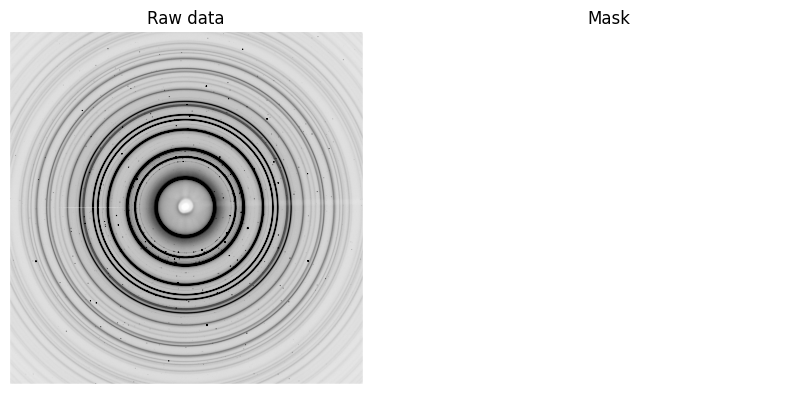

In [26]:
from site import abs_paths
import time
temp_path = 'data/Perfect/masks/'
inp_path = 'data/Perfect/'

inp_images = glob(inp_path + '*.tif')
mask_images = glob(temp_path + '*.tif')

inp_images.sort(key=lambda x: x.split('/')[-1])
mask_images.sort(key=lambda x: x.split('/')[-1])

i = 0

#Time the code below
start = time.time()

test_im = iio.v2.volread(inp_images[0])
mask_im = iio.v2.volread(mask_images[0])
#test_im_norm = normalize(test_im)


#Stop recording time
end = time.time()
#Plot positions of all nonzero elements in test_im
plt.figure(figsize=(10,10))
#If plotting regular images use vmin=0, vmax=15000
fig, ax = plt.subplots(1,2, figsize=(10,10))
#Rescale test_im colors
ax[0].imshow(test_im, cmap='binary', origin='lower', vmin=0, vmax=15000)
# ax[0].imshow(test_im, cmap='binary', origin='lower',)
ax[0].set_title('Raw data')
ax[0].axis('off')

ax[1].imshow(mask_im, cmap='binary', origin='lower',)
ax[1].set_title('Mask')
ax[1].axis('off')


print(f'Time to load image: {end-start} seconds')

Time to grab input/target: 0.003425121307373047 seconds


(-0.5, 255.5, -0.5, 255.5)

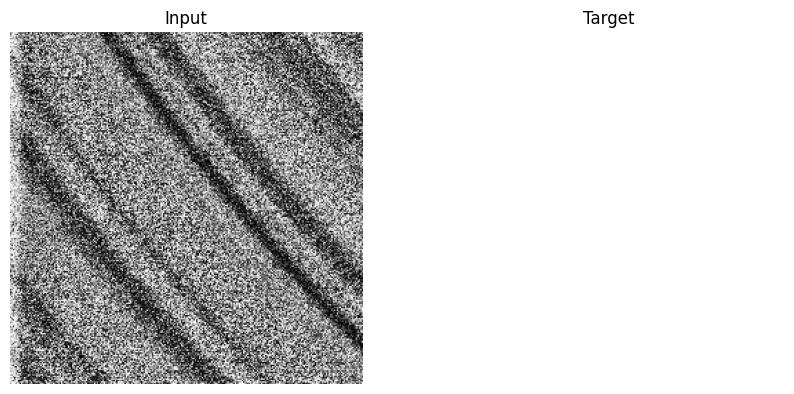

In [15]:
#Grab one of the inputs from powder_dataset and time that process
import time
start = time.time()
input, target = powder_dataset[2]
end = time.time()
print(f'Time to grab input/target: {end-start} seconds')

#Plot squeezed input and target side by side
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(input.squeeze(), cmap='binary', origin='lower',)
ax[0].set_title('Input')
ax[0].axis('off')
ax[1].imshow(target.squeeze(), cmap='binary', origin='lower',)
ax[1].set_title('Target')
ax[1].axis('off')

# Create/load a specific dataset

Here, we'll be utilizing the auto-masking process developed in __ to automatically generate labelled/segmented data for artifact identification.


In [ ]:
Samples = glob('data/*')
mask_folder = 'masks'

for path_to_sample in Samples:

    path_to_sample = path_to_sample + '/'

    if not os.path.isdir(path_to_sample + mask_folder):
        #Grabbing imctrl file and parsing its contents. If no imctrl file exists, skip this
        try:
            imctrl_file = glob(path_to_sample + '*.imctrl')[0]
        except:
            continue
        else:
            #Assign controls
            controls = parse_imctrl(imctrl_file)

            #Creating mask, need to specify image size here
            #This MASK function was developed from a previous publication by Yanxon et al.
            mask = MASK(controls=controls, shape=(2880,2880))

            #Creating mask directory
            os.mkdir(path_to_sample + mask_folder)
            paths = glob(path_to_sample + '*.tif')

            #Generate masked image for each sample image and save it in a mask subdirectory for a specific dataset
            for path in paths:
                image_name = path.split('/')[-1][:-4]
                image = iio.v2.volread(path)
                result = mask.AutoSpotMask(image, esdmul=7.0)
                iio.v2.imwrite(path_to_sample + f'{mask_folder}/{image_name}_mask.tif', result)


# Creating dataset/dataloaders for training

# Running locally with memory constraints (e.g. < 16 gb RAM)

### Image normalization and centralized directory

First we'll apply a normalization process to the images and save it as a separate image. We don't apply this as part of a transformation pipeline because we normalize an entire powder diffraction images (2880 x 2800 pixels), while the input windows (256 x 256 pixels) used for training and inference are not each normalized separately. 

This way we perform the normalization once for every image independently, and we can then dice up the image however we choose.

In [3]:
import re
import airxd_cnn
from airxd_cnn.transforms import powder_normalize
from airxd_cnn.powder_dataset_v2 import powder_dset
#In the line below, filter out for any names with 'normalized'

In [4]:
def create_normalized_images(directory, class_paths):
    if not os.path.isdir(directory):
        os.mkdir(directory)

    for path_to_class in class_paths:
        path_identifier = path_to_class + '/' + '*.tif'
        sample_paths = glob(path_identifier)

        #Load images, normalize and save them
        for path in sample_paths:
            image_name = path.split('/')[-1][:-4]
            full_file_path = directory + f'/{image_name}_norm.tif'
            
            #If full_file_path doesn't exist, excecute below code
            if not os.path.isfile(full_file_path):
                image = iio.v2.volread(path)
                image_norm = powder_normalize(image)
                iio.v2.imwrite(directory + f'/{image_name}_norm.tif', image_norm)

In [5]:
#List of acceptable classes for training
train_classes = ['Nickel', 'battery1', 'battery2', 'battery3', 'battery4', 'Perfect']

#Define class_paths as any directories in classes

class_paths = [f for f in glob('data/*') if f.split('/')[-1] in train_classes]
mask_paths = [f for f in glob('data/*/masks/*.tif') if f.split('/')[1] in train_classes]

#Normalize images within each class folder and save in separate subfolder
normalized_dir = 'data/normalized_train'

#Creates normalized images if they don't exist, does nothing if they do
create_normalized_images(normalized_dir, class_paths)


In [6]:
#Do the same thing with the validation directory
normalized_dir = 'data/normalized_valid'

valid_classes = ['battery5']

#Define class_paths as any directories in classes
class_paths = [f for f in glob('data/*') if f.split('/')[-1] in valid_classes]
mask_paths = [f for f in glob('data/*/masks/*.tif') if f.split('/')[1] in valid_classes]

normalized_dir = 'data/normalized_valid'

create_normalized_images(normalized_dir, class_paths)



### Constructing a dataset object with normalized experimental images

Here we'll grab put all relevant tif files into a dataset

In [7]:
normalized_dir = 'data/normalized_train'

#Exclude the fifth battery dataset
input_paths = [f for f in glob(normalized_dir + '/*.tif') if not re.search(r'BYS', f)]
mask_paths = [f for f in glob('data/*/masks/*.tif') if f.split('/')[1] in train_classes]

#Sort input/mask paths by the last part of the filename
#This way the indices will match up between the correct files
input_paths.sort(key=lambda x: x.split('/')[-1].split('_norm')[0])
mask_paths.sort(key=lambda x: x.split('/')[-1].split('_mask')[0])




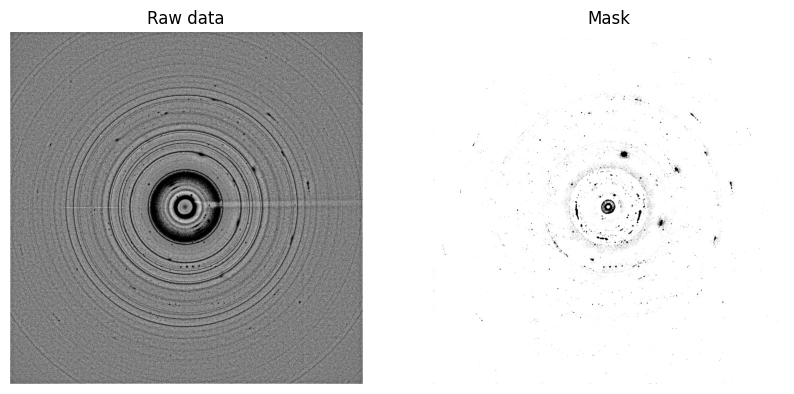

In [8]:
plot_im_and_mask(input_paths[30], mask_paths[30])

In [11]:
from airxd_cnn.transforms import RandomRotation, RandomFlip

In [261]:
#Reimport airxd_cnn using importlib
import importlib
importlib.reload(airxd_cnn.powder_dataset_v2)

<module 'airxd_cnn.powder_dataset_v2' from '/home/av_linux/Fork/AIRXD-CNN/airxd_cnn/powder_dataset_v2.py'>

In [262]:
#Define transforms
from airxd_cnn.powder_dataset_v2 import powder_dset

transform_pipeline = v2.Compose([
    RandomRotation(),
    RandomFlip()
])

#Quilter params
#We will be cropping 20 pixels off of each side because the auto-labeler often labels edges.
#That results in poor training labels
side_crop = 20
image_d = 2880
N = 256
M = N // 2
B = M // 4
quilter_params = {'Y': image_d - 2*side_crop,
                  'X': image_d - 2*side_crop,
                  'window': (N, N),
                  'step': (M, M),
                  'border': (B, B),
                  'border_weight': 0,
                  'crop': side_crop}

#Other relevant params
other_params = {"transforms": transform_pipeline,
          "input_map_path": 'data/input_mmap',
          "target_map_path": 'data/target_mmap',
          "device": 'cuda:0',
          "minority_threshold": 30,
          "create_memmap": True}

#Create dataset object
powder_dataset = powder_dset(input_paths, mask_paths, quilter_params, **other_params)

Creating memory map of input and target paths...


86it [00:55,  1.56it/s]
86it [00:30,  2.86it/s]


Done!


In [266]:
#Create training and validation dataloaders
from torch.utils.data import Subset, DataLoader
from torch.utils.data import random_split
from torch import Generator

#Set seeds with np and generator
seed = 42
np.random.seed(seed)
generator = Generator().manual_seed(seed)

#Use subset to balance the number of "good" and "bad" examples in training
n_good = len(powder_dataset.good_indices)
good_indices = powder_dataset.good_indices

n_bad = min(int(1.5 * n_good), len(powder_dataset.bad_indices))
bad_indices = powder_dataset.bad_indices
#Shuffle bad indices before splitting off
np.random.shuffle(bad_indices)

subset_indices = good_indices.copy()
# subset_indices.extend(bad_indices[:n_bad])

#Create a subset of the good indices
balanced_dataset = Subset(powder_dataset, subset_indices)

#Subsample balanced dataset for speed, then into 80:20 using random_split
sample_pct = 0.6
remaining = 1 - sample_pct

sample_dset, rest = random_split(balanced_dataset,
                                 [sample_pct, remaining],
                                 generator = generator)
train_dataset, val_dataset = random_split(sample_dset,
                                          [0.8, 0.2],
                                          generator = generator)

# #Create dataloaders using balanced, subsampled train and validation datasets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True, drop_last=True)

In [268]:
importlib.reload(airxd_cnn.model)

<module 'airxd_cnn.model' from '/home/av_linux/Fork/AIRXD-CNN/airxd_cnn/model.py'>

In [269]:
torch.cuda.empty_cache()

In [270]:
from airxd_cnn.model import ARIXD_CNN

#Define TUNet params (from dlsia)
model_params = {'image_shape': (256, 256),
                'in_channels': 1,
                'out_channels': 2,
                'base_channels': 8,
                'growth_rate': 2,
                'depth': 4}

#Define other training params in loop.
training_params = {'device': 'cuda:0',
                   'amp': False,
                   'clip_value': None,
                   'epoch': 20,
                   'batch_size': batch_size,
                   'shuffle': True,
                   'drop_last': True,
                   'lr_rate': 1e-2,
                   'weights': [1.0, 10.0],
                   'save_path': 'models_06_26_2024_large_noborder'}

# Quilter params
                   
cnn_model = ARIXD_CNN(model_params, training_params, quilter_params)

In [271]:
cnn_model.train(train_loader,val_loader)

====================== Training ======================
Epoch 1 of 20 | Learning rate 1.000e-02
   Training Loss: 3.1061e-01 | Validation Loss: 2.3539e-01
   Micro Training F1: 0.9510 | Micro Validation F1: 0.9606
   Macro Training F1: 0.5700 | Macro Validation F1: 0.6098
   Network intermittently saved

Epoch 2 of 20 | Learning rate 1.000e-02
   Training Loss: 2.1711e-01 | Validation Loss: 1.9147e-01
   Micro Training F1: 0.9662 | Micro Validation F1: 0.9713
   Macro Training F1: 0.6515 | Macro Validation F1: 0.6623
   Network intermittently saved

Epoch 3 of 20 | Learning rate 1.000e-02
   Training Loss: 2.0512e-01 | Validation Loss: 1.8932e-01
   Micro Training F1: 0.9643 | Micro Validation F1: 0.9772
   Macro Training F1: 0.6547 | Macro Validation F1: 0.6748
   Network intermittently saved

Epoch 4 of 20 | Learning rate 1.000e-02
   Training Loss: 1.8833e-01 | Validation Loss: 1.6378e-01
   Micro Training F1: 0.9653 | Micro Validation F1: 0.9681
   Macro Training F1: 0.6668 | Macro 

In [272]:
cnn_model.save('models_06_26_2024_large_noborder/final_model.pt')

In [24]:
path_to_model = 'models_06_26_2024/net_checkpoint'
cnn_model.model.load_state_dict(torch.load(path_to_model))
cnn_model.model.to('cuda:0')

TUNet(
  (activation): ReLU()
  (Encode_0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Decode_0): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (Step Down 0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=1, ceil_mode=False)
  (Step Up 0): ConvTranspose2d(16, 8,

In [25]:
valid_classes = ['battery5']

valid_input_paths= [f for f in glob('data/normalized_valid/*.tif')]
valid_mask_paths = [f for f in glob('data/*/masks/*.tif') if f.split('/')[1] in valid_classes]

#Sort input/mask paths by the last part of the filename
valid_input_paths.sort(key=lambda x: x.split('/')[-1].split('_')[0])
valid_mask_paths.sort(key=lambda x: x.split('/')[-1].split('_')[0])

valid_input_paths

['data/normalized_valid/BYS-900-00000-00001_norm.tif',
 'data/normalized_valid/BYS-900-00000-00002_norm.tif',
 'data/normalized_valid/BYS-900-00000-00003_norm.tif',
 'data/normalized_valid/BYS-900-00000-00004_norm.tif',
 'data/normalized_valid/BYS-900-00000-00005_norm.tif',
 'data/normalized_valid/BYS-900-00000-00007_norm.tif',
 'data/normalized_valid/BYS-900-00000-00008_norm.tif',
 'data/normalized_valid/BYS-900-00000-00009_norm.tif',
 'data/normalized_valid/BYS-900-00000-00010_norm.tif',
 'data/normalized_valid/BYS-900-00000-00011_norm.tif',
 'data/normalized_valid/BYS-900-00000-00012_norm.tif',
 'data/normalized_valid/BYS-900-00000-00013_norm.tif',
 'data/normalized_valid/BYS-900-00000-00014_norm.tif',
 'data/normalized_valid/BYS-900-00000-00015_norm.tif']

In [276]:
cnn_model.quilter = cnn_model.set_quilter({'Y': image_d,
                  'X': image_d,
                  'window': (N, N),
                  'step': (M, M),
                  'border': (B, B),
                  'border_weight': 0,
                  'crop': side_crop})

In [295]:
input_paths[26:35]

['data/normalized_train/Kinnto2-00000-00001_norm.tif',
 'data/normalized_train/Kinnto2-00000-00002_norm.tif',
 'data/normalized_train/Kinnto2-00000-00003_norm.tif',
 'data/normalized_train/Kinnto2-00000-00004_norm.tif',
 'data/normalized_train/Kinnto2-00000-00005_norm.tif',
 'data/normalized_train/Kinnto2-00000-00006_norm.tif',
 'data/normalized_train/Kinnto2-00000-00007_norm.tif',
 'data/normalized_train/Kinnto2-00000-00008_norm.tif',
 'data/normalized_train/Kinnto2-00000-00009_norm.tif']

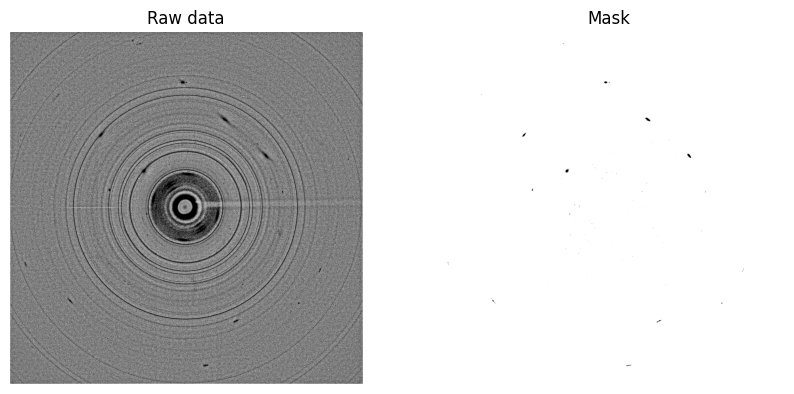

In [301]:
i = 38
plot_im_and_mask(input_paths[i], mask_paths[i])

In [329]:
i = 63
print(input_paths[i])
label_pred = cnn_model.predict_old(input_paths[i],0.1)
label = np.array(iio.v2.volread(mask_paths[i]))

#plot input_paths[i], label_pred and label
fig, ax = plt.subplots(1,3, figsize=(10,10))
im = iio.v2.volread(input_paths[i])
ax[0].imshow(im, cmap='binary', origin='lower',)
ax[0].set_title('Input')
ax[0].axis('off')
ax[1].imshow(label_pred, cmap='binary', origin='lower',)
ax[1].set_title('Label_pred')
ax[1].axis('off')
ax[2].imshow(label, cmap='binary', origin='lower',)
ax[2].set_title('Label')
ax[2].axis('off')


data/normalized_train/TC-2-00000-00003_norm.tif


: 

(-0.5, 2879.5, -0.5, 2879.5)

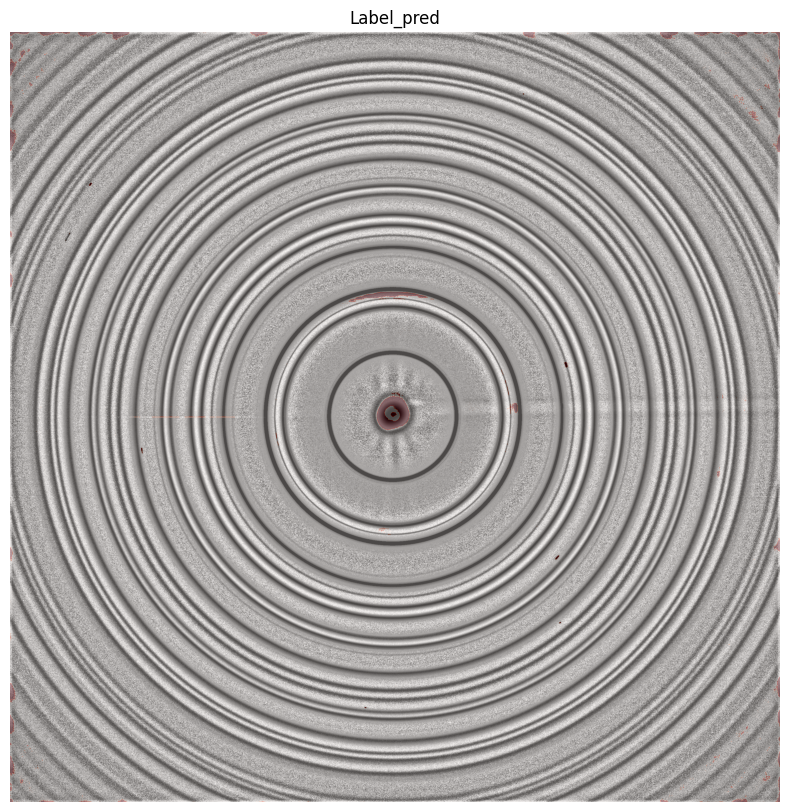

In [328]:
#Superimpose label_pred on im. Label_pred should be red
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(im, cmap='binary', origin='lower',)
ax.imshow(label_pred, cmap='Reds', origin='lower', alpha=0.3)
ax.set_title('Label_pred')
ax.axis('off')


In [304]:
from sklearn.metrics import confusion_matrix as CM

In [324]:
matrix = CM(label.ravel(), label_pred.ravel())

mattol = np.zeros(4)
mattol += matrix.ravel()
tn, fp, fn, tp = matrix.ravel()
tn_rate = tn/(fp+tn)*100
tp_rate = tp/(fn+tp)*100

print(f'True Negative   : {tn}')
print(f'False Positive  : {fp}')
print(f'False Negative  : {fn}')
print(f'True Positive   : {tp}')
print(f'True TN rate    : {round(tn_rate,1)} %')
print(f'True TP rate    : {round(tp_rate,1)} %')
print('\n')

True Negative   : 8233875
False Positive  : 40171
False Negative  : 7250
True Positive   : 13104
True TN rate    : 99.5 %
True TP rate    : 64.4 %




(-0.5, 2879.5, -0.5, 2879.5)

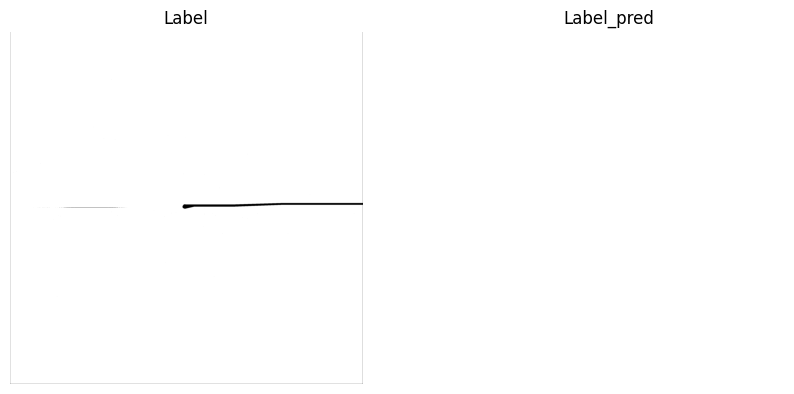

In [86]:
#Plot label and labe_pred images
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(label, cmap='binary', origin='lower',)
ax[0].set_title('Label')
ax[0].axis('off')
ax[1].imshow(label_pred, cmap='binary', origin='lower',)
ax[1].set_title('Label_pred')
ax[1].axis('off')


In [ ]:
params = {"im_size": (2880, 2880),
          "window_size": (256, 256),
          "transforms": transform_pipeline,
          "input_map_path": 'data/test_input_mmap',
          "target_map_path": 'data/test_target_mmap'}

#Create a new dataset for image inference
powder_dataset = powder_dset(input_paths, mask_paths, **params)

In [8]:
#reload library qlty2d
importlib.reload(qlty2D)

NameError: name 'qlty2D' is not defined

In [39]:
#Test out quilt to see if it's causing issues
import qlty
from qlty import qlty2D

quilt = qlty2D.NCYXQuilt(X=2880,
                         Y=2880,
                         window=(256,256),
                         step=(128,128),
                         border=(32,32),
                         border_weight=0)

In [25]:
import einops
import torch

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [24]:

test_im = iio.v2.volread(input_paths[0])
_image = einops.rearrange(test_im, "Y X -> () () Y X")

_image = torch.Tensor(_image).to(device) 
image = quilt.unstitch(_image)
stitched_image = quilt.stitch(image)
#Move stitched_image to cpu
stitched_image = stitched_image[0].to('cpu')


(-0.5, 2879.5, -0.5, 2879.5)

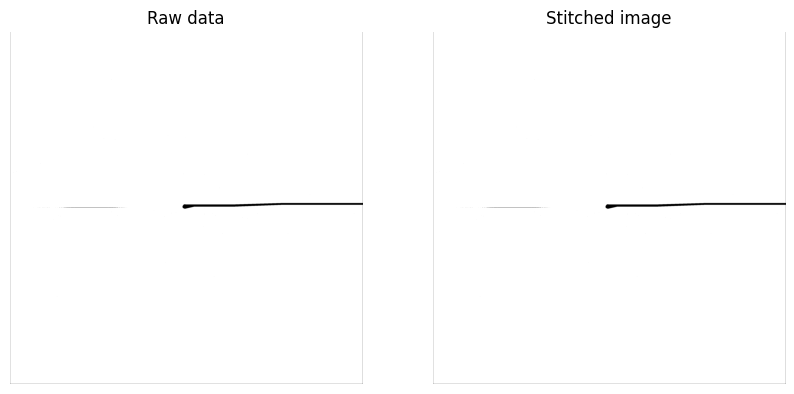

In [25]:
#plot stitched_image and test_im side by side
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(test_im, cmap='binary', origin='lower',)
ax[0].set_title('Raw data')
ax[0].axis('off')
ax[1].imshow(stitched_image.squeeze(), cmap='binary', origin='lower',)
ax[1].set_title('Stitched image')
ax[1].axis('off')


 ## Step by step inference checking

In [37]:
from torch import nn
import einops

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [40]:
test_im = iio.v2.volread(input_paths[1])
_image = einops.rearrange(test_im, "Y X -> () () Y X")

_image = torch.Tensor(_image).to(device) 
image = quilt.unstitch(_image)


In [41]:
with torch.no_grad():
    test = cnn_model.model(image)
#Lags a bit but not a big deal with full image

In [29]:
test_softmax = nn.Softmax(dim=1)(test)
test.device, test_softmax.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [30]:
test_softmax.shape

torch.Size([484, 2, 256, 256])

In [31]:
# stitched_test = quilt.stitch(test.to('cpu'))
stitched_test = quilt.stitch(test_softmax)



In [32]:
res = []

In [33]:
for i, test in enumerate(stitched_test):
    res.append(test[i].to('cpu').numpy())

In [37]:
res[0][0].shape

(2880, 2880)

In [54]:
result_[0][0].shape

torch.Size([2880, 2880])

In [61]:
result = np.zeros((2880, 2880), dtype=float)
result += np.array(result_[0,0]<0.1, dtype=float)

In [89]:
res[0][0].shape

(2880, 2880)

In [11]:
test_pred = cnn_model.predict_old(input_paths[0])

TypeError: Invalid shape () for image data

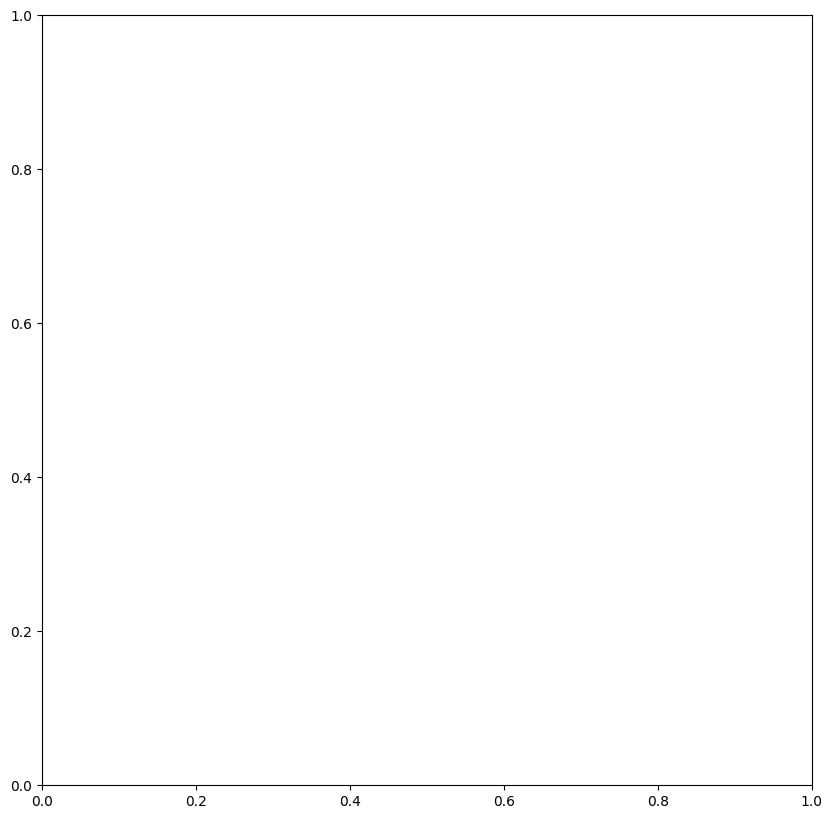

In [103]:
#plot test_pred image
plt.figure(figsize=(10,10))
plt.imshow(result_2, cmap='binary', origin='lower')